# Class Activation Maps

In [35]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from tensorflow.keras.models import Model

import matplotlib.pyplot as plt
import cv2
import scipy as sp

import glob
import random
import numpy as np

In [12]:
import os
from kaggle.api.kaggle_api_extended import KaggleApi

os.environ['KAGGLE_USERNAME'] = "xxxxx"                 #Manually input from kaggle
os.environ['KAGGLE_KEY'] = "xxxxx"   #Manually input from kaggle

api = KaggleApi()
api.authenticate()

api.dataset_download_files('viratkothari/animal10', path="./Images/", unzip=True)
del api

In [16]:
animals = []
for animal in glob.glob("./Images/Animals-10/*"):
  animal = animal.split('/')[-1]
  for path in glob.glob("./Images/Animals-10/" + animal + "/*" ):
    animals.append((animal, path))

In [ ]:
resnet = ResNet50(include_top = True, weights = 'imagenet')
resnet.summary()

In [70]:
last_act_layer = resnet.get_layer('conv5_block3_out')
model = Model(inputs = resnet.input, outputs = last_act_layer.output)

In [8]:
last_dense_layer = resnet.get_layer('predictions')
weights = last_dense_layer.get_weights()[0]

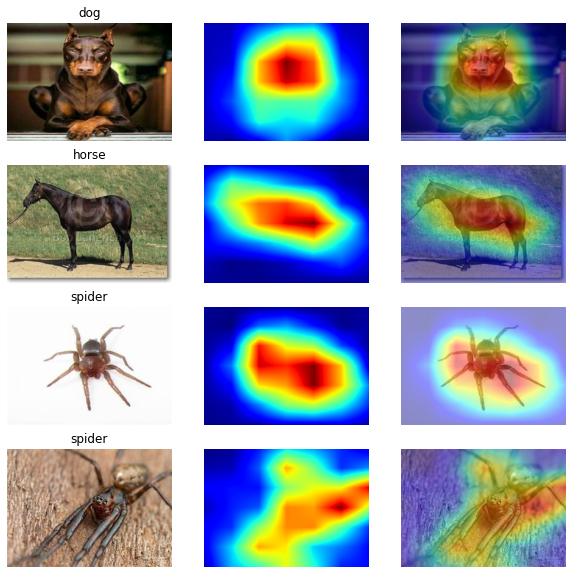

In [75]:
plt.rcParams["figure.figsize"] = (10,10)
fig, axs = plt.subplots(4,3)

for i in range(4):
  number = random.randint(0, len(animals))

  label,path = animals[number]
  img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
  img = cv2.resize(img, (224, 224))

  img_ = preprocess_input(np.expand_dims(img, axis = 0))

  feature_maps = model.predict(img_, verbose = 0)       #1 x 7 x 7 x 2048
  
  prediction = resnet.predict(img_, verbose = 0)        
  decoded_prediction = decode_predictions(prediction)[0][1]
  
  cam = feature_maps[0].dot( weights[:, np.argmax(prediction)] )

  #Upsample cam from 7x7 to 224,224
  cam = sp.ndimage.zoom(cam, (32,32), order=1)

  axs[i][0].imshow(img, aspect='auto')
  axs[i][0].set_title(label)
  axs[i][0].axis("off")

  axs[i][1].imshow(cam, cmap = 'jet', aspect='auto')
  axs[i][1].axis("off")

  axs[i][2].imshow(img, alpha = 1, aspect='auto')
  axs[i][2].imshow(cam, cmap = 'jet', alpha = 0.45, aspect='auto')
  axs[i][2].axis("off")